In [1]:
import jax
jax.config.update("jax_enable_x64", True)

import numpyro
numpyro.set_host_device_count(4)

%load_ext autoreload
%autoreload 2

import h5py
import numpy as np
import scipy.optimize
import jax.numpy as jnp

import ultraplot as uplt

## Look at n(z) Distributions and Perturbations

In [2]:
from des_y6_nz_modeling import sompz_integral

with h5py.File("N_gamma_alpha_v1.hdf5") as d:
    z = d["redshift/true/zbinsc"][:].astype(np.float64)

    nzs = {}
    for _bin in range(4):
        nzs[_bin] = d[f"redshift/true/bin{_bin}"][:].astype(np.float64)
        nzs[_bin] = nzs[_bin] / np.sum(nzs[_bin])

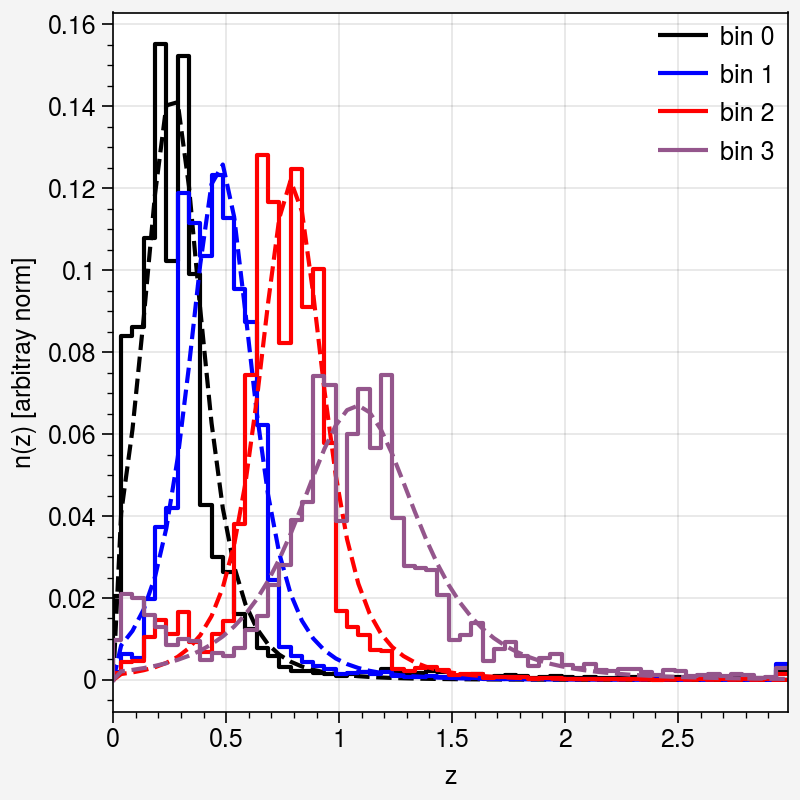

In [3]:
from mstudt4 import fit_nz_data_for_template_params, mstudt_nrm

params = fit_nz_data_for_template_params(z, nzs)

fig, axs = uplt.subplots(figsize=(4, 4))

for i, col in enumerate(["black", "blue", "red", "purple"]):
    popt = params[i]
    axs.plot(z, nzs[i], drawstyle="steps", color=col, label=f"bin {i}")
    axs.plot(z, mstudt_nrm(z, *popt), linestyle="dashed", color=col)

axs.format(xlabel="z", ylabel="n(z) [arbitray norm]")
axs.legend(loc="ur", frameon=False, ncols=1)

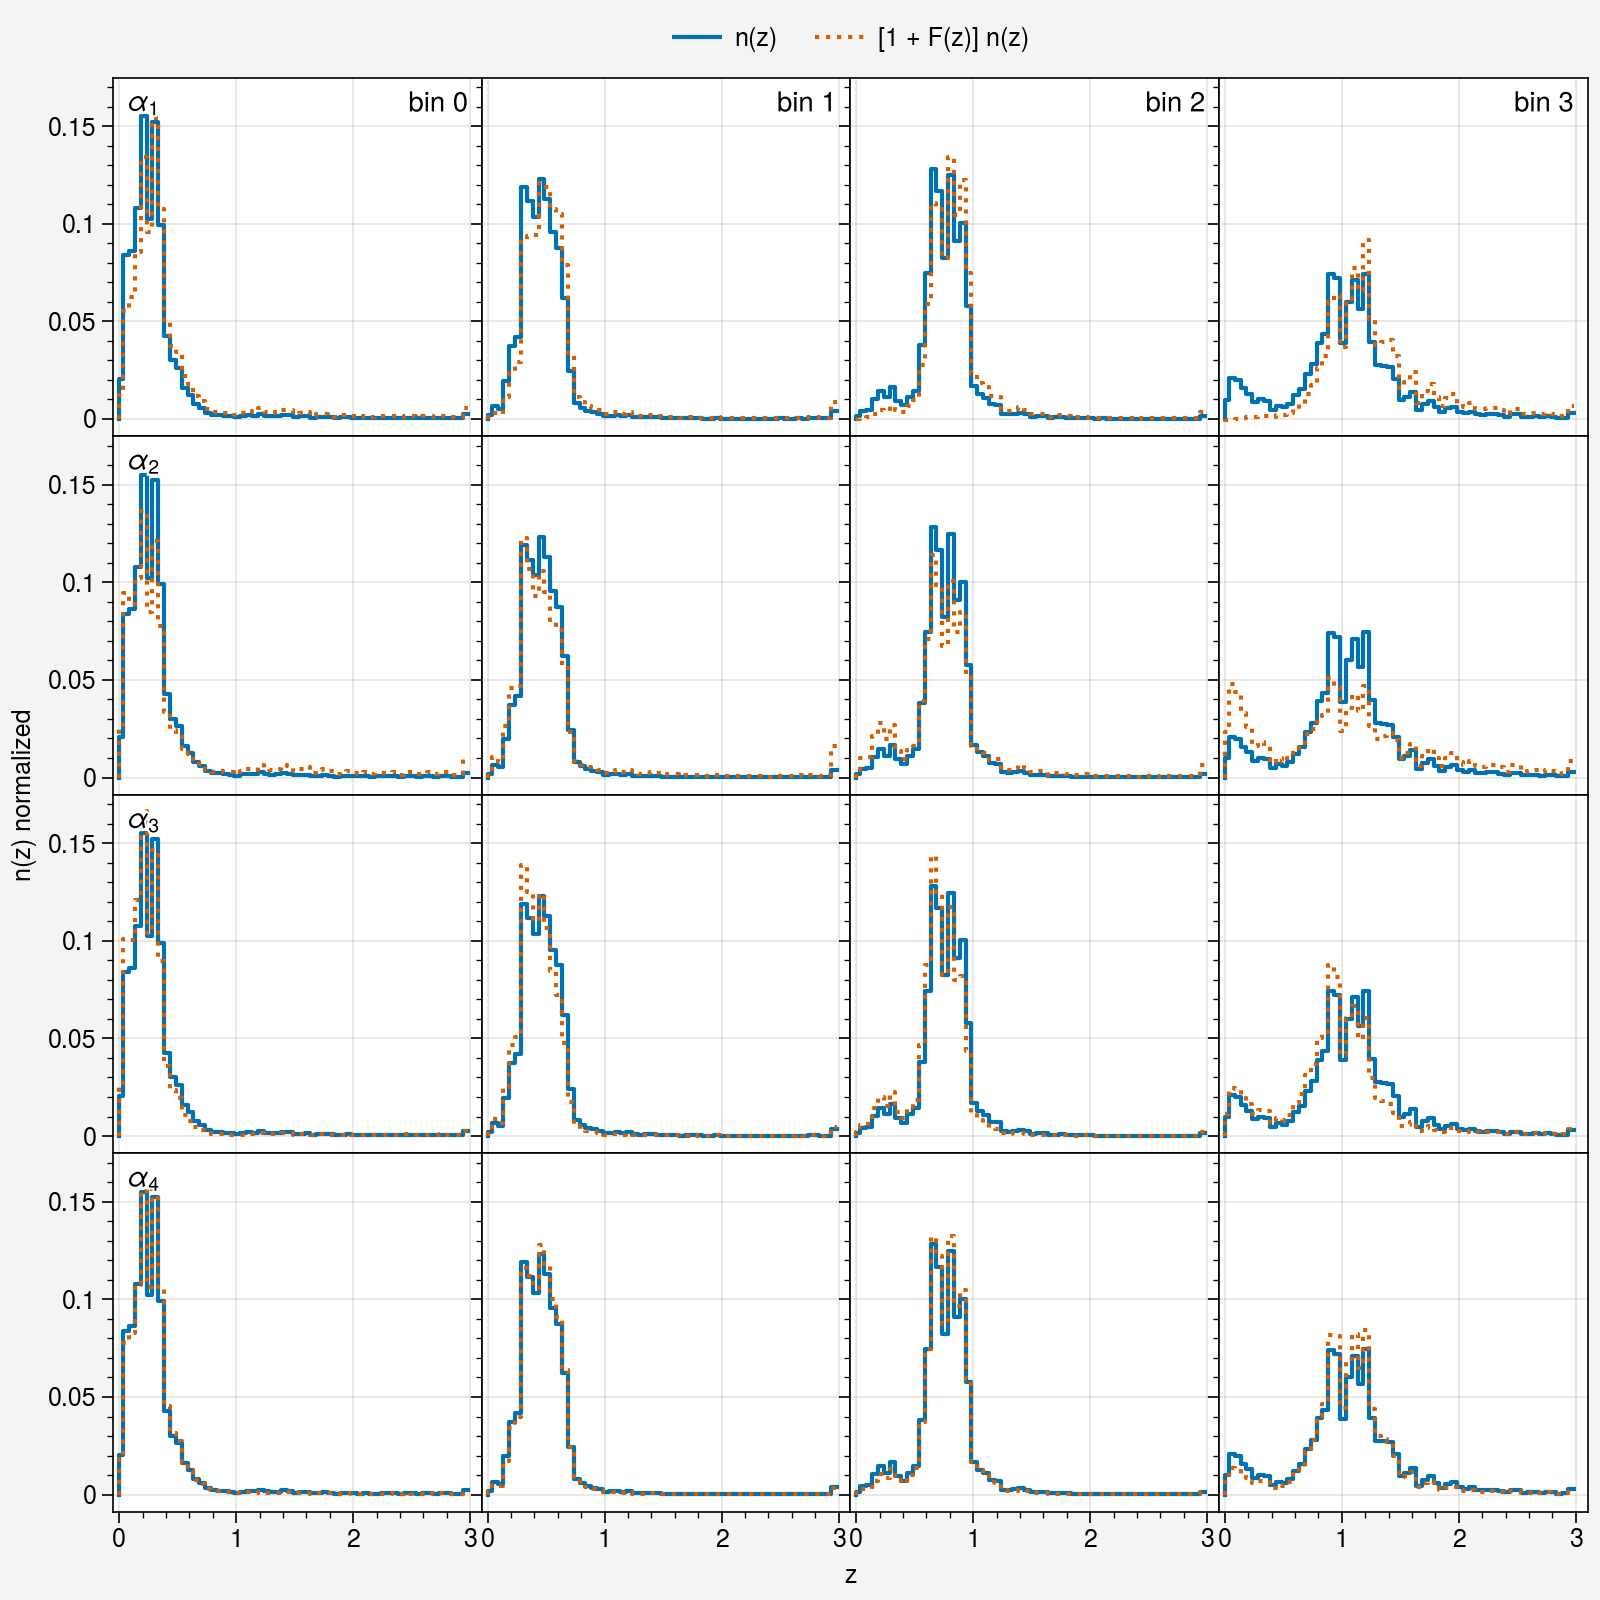

In [4]:
from mstudt4 import fmodel_mstudt4
from des_y6_nz_modeling import compute_nz_binned_mean

scales = np.ones(4)

fig, axs = uplt.subplots(ncols=4, nrows=4, figsize=(8, 8), share=4, wspace=0, hspace=0)

for i in range(4):
    for row in range(4):
        ax = axs[row, i]
        avec = np.zeros(4)
        avec[row] = scales[row]

        nzi = nzs[i]
        stud_params = params[i]

        morig = ax.plot(z, nzi, drawstyle="steps", label="n(z)")
        mui = compute_nz_binned_mean(nzi)

        fac = 1.0 + fmodel_mstudt4(z, 0.0, avec[0], avec[1], avec[2], avec[3], mui, 1.0)  # stud_params[0], stud_params[1])
        nzi_fmodel = nzi * fac
        nzi_fmodel /= np.sum(nzi_fmodel)
        mmod = ax.plot(z, nzi_fmodel, drawstyle="steps", linestyle="dotted", label="[1 + F(z)] n(z)")

        ax.format(xlim=(-0.05, 3.1))
        if row == 0:
            ax.format(urtitle=f"bin {i}")
        if i == 0:
            ax.format(ultitle=f"$\\alpha_{row+1}$", ylabel="n(z) normalized")
        if row == 3:
            ax.format(xlabel="z")

fig.legend([morig, mmod], loc="t", frameon=False, ncols=3)

## Plot the N_gamma_alpha Data

In [5]:
with h5py.File("N_gamma_alpha_v1.hdf5") as d:
    mn = d["shear/mean"][:].astype(np.float64)
    cov = d["shear/cov"][:].astype(np.float64)
    mn_pars = tuple(tuple(v) for v in d["shear/mean_params"][:].astype(np.int64).tolist())
    zbins = []
    for zbin in range(-1, 10):
        zbins.append(d[f"alpha/bin{zbin}"][:].astype(np.float64))
    zbins = np.array(zbins)

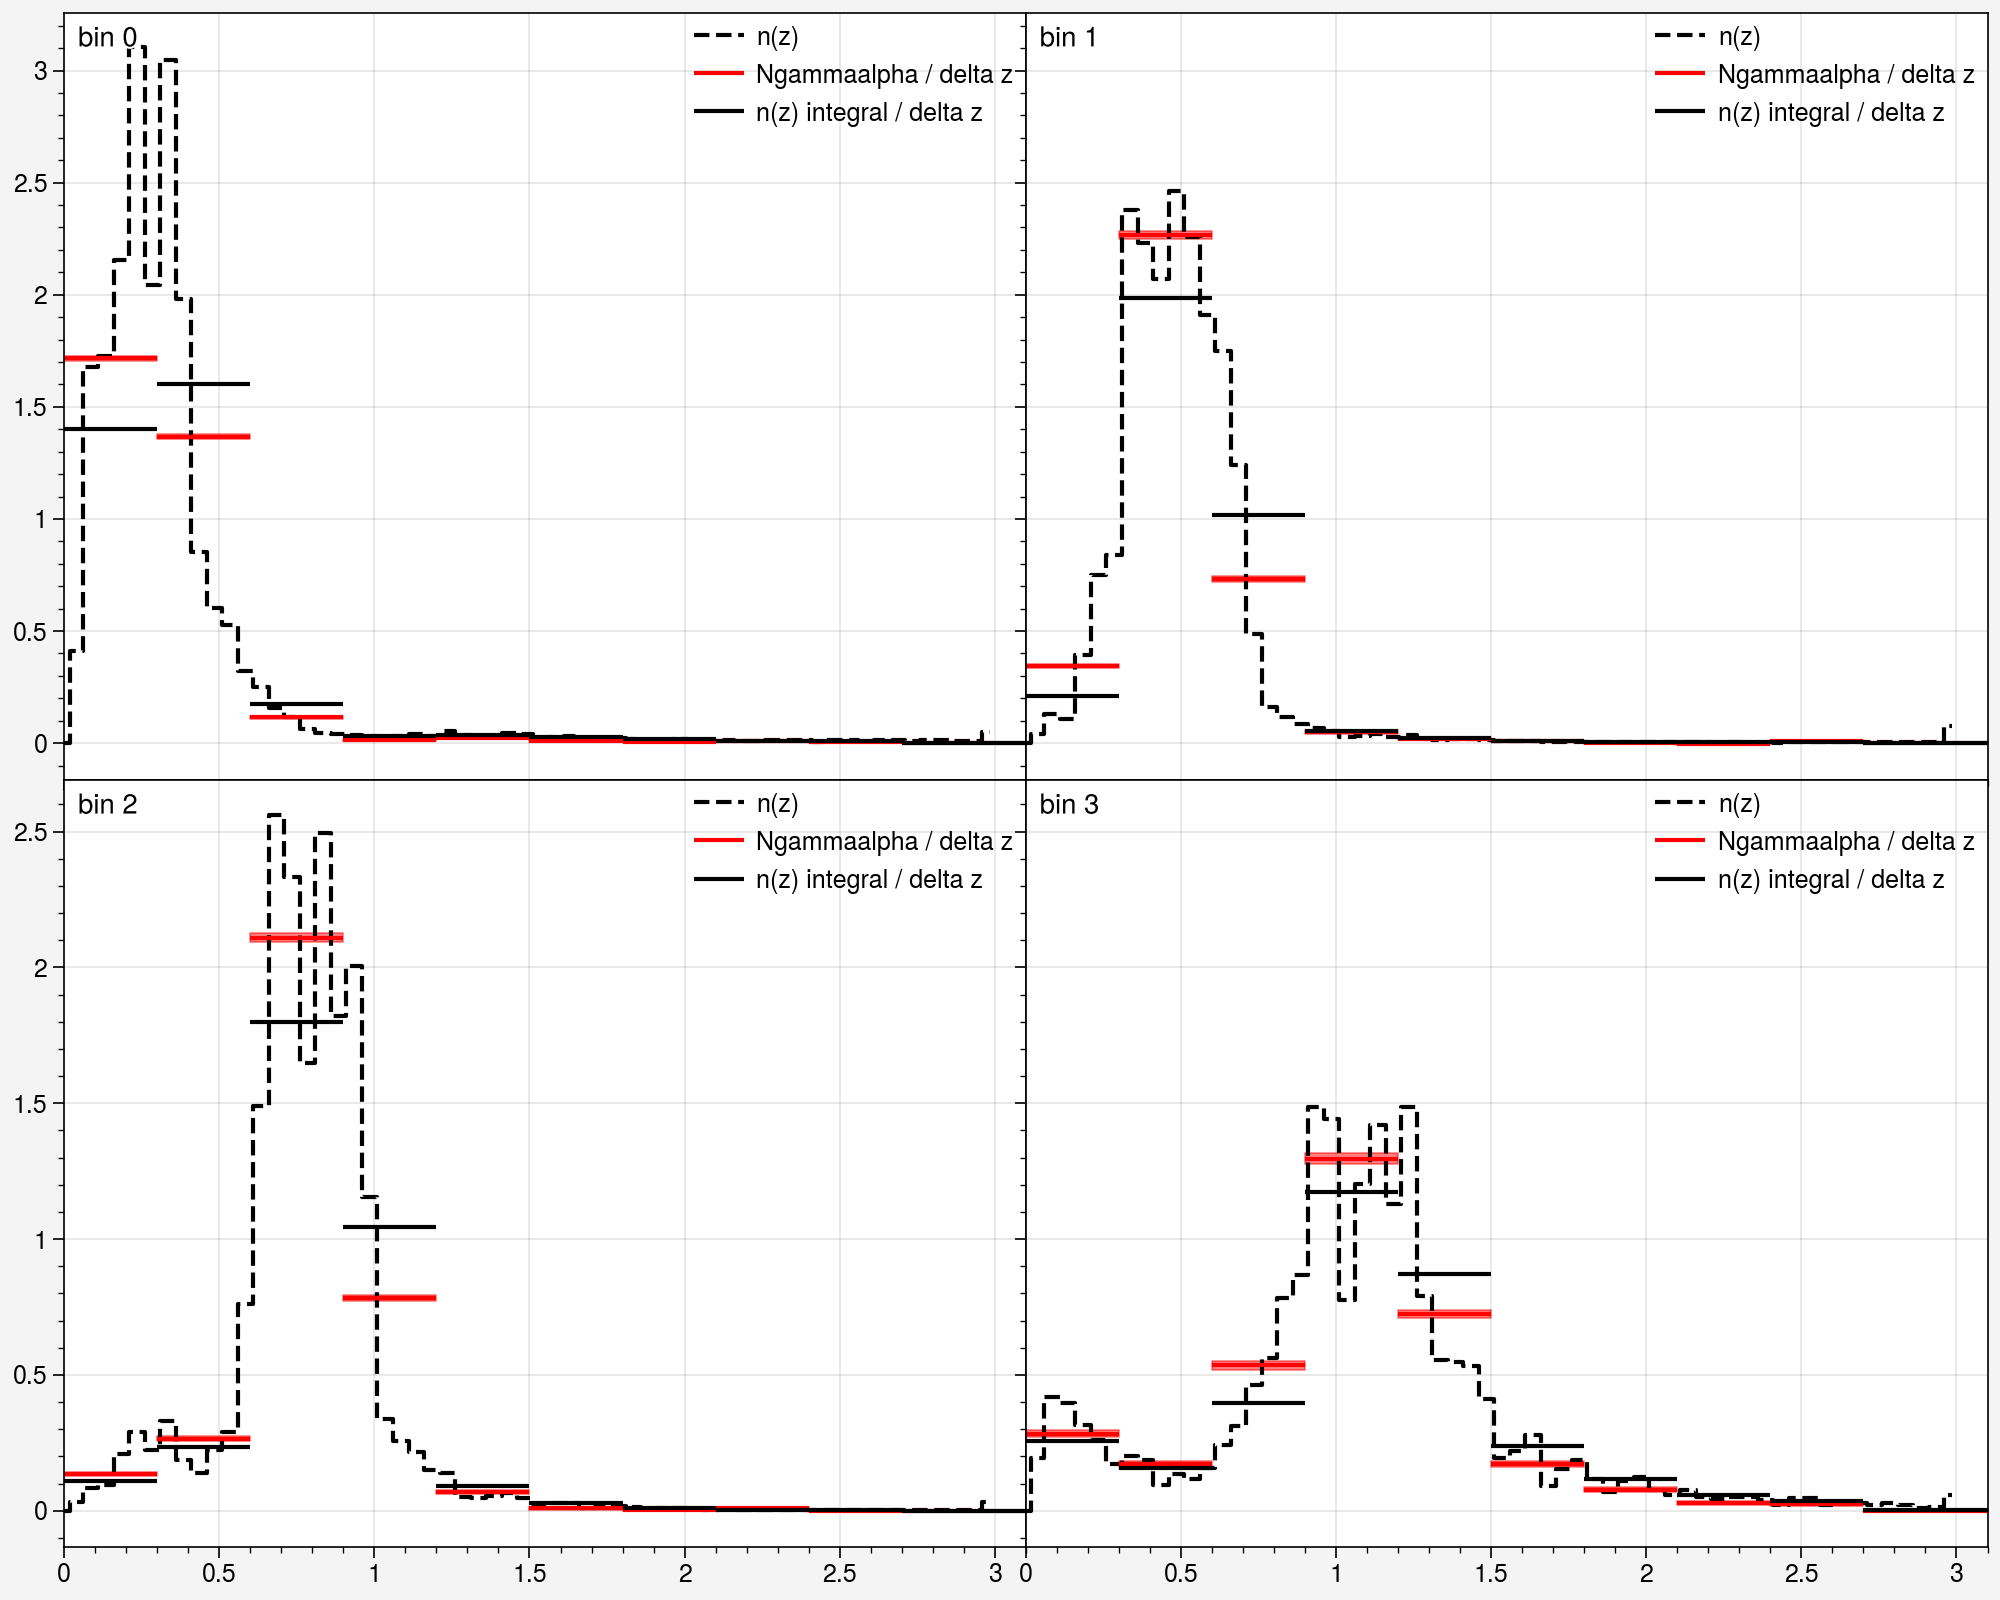

In [6]:
from des_y6_nz_modeling import DZ

fig, axs = uplt.subplots(nrows=2, ncols=2, figsize=(10, 8), hspace=0, wspace=0)

for bi in range(4):
    biy, bix = np.unravel_index(bi, (2, 2))
    ax = axs[biy, bix]
    ax.plot(z, nzs[bi] / DZ, drawstyle="steps-mid", color="black", linestyle="dashed", label="n(z)")

    for i in range(10):
        nind = mn_pars.index((i, bi))
        bin_zmin, bin_zmax = zbins[i+1]
        bin_dz = bin_zmax - bin_zmin
        nga_val = mn[nind] / bin_dz
        nga_err = np.sqrt(cov[nind, nind]) / bin_dz
        ax.fill_between(
            [bin_zmin, bin_zmax],
            np.ones(2) * nga_val - nga_err,
            np.ones(2) * nga_val + nga_err,
            color="red",
            alpha=0.5,
        )

        ax.hlines(
            mn[nind] / bin_dz,
            bin_zmin,
            bin_zmax,
            color="red",
            label="Ngammaalpha / delta z" if i == 0 else None,
        )
        ng_val = sompz_integral(nzs[bi], bin_zmin, bin_zmax) / bin_dz
        ax.hlines(
            ng_val,
            bin_zmin,
            bin_zmax,
            color="black",
            label="n(z) integral / delta z" if i == 0 else None,
        )
    ax.legend(loc="ur", frameon=False, ncols=1)
    ax.format(xlim=(0, 3.1), title=f"bin {bi}", titleloc="ul")


## Fit the Data

In [7]:
import numpyro
from numpyro.infer import MCMC, NUTS

In [8]:
import mstudt4

with h5py.File("N_gamma_alpha_v1.hdf5") as d:
    mn = d["shear/mean"][:].astype(np.float64)
    cov = d["shear/cov"][:].astype(np.float64) * 2.0
    mn_pars = tuple(tuple(v) for v in d["shear/mean_params"][:].astype(np.int64).tolist())
    zbins = []
    for zbin in range(-1, 10):
        zbins.append(d[f"alpha/bin{zbin}"][:].astype(np.float64))
    zbins = np.array(zbins)


model_module = mstudt4

model_data = model_module.make_model_data(
    z=z,
    nzs=nzs,
    mn=mn,
    cov=cov,
    mn_pars=mn_pars,
    zbins=zbins,
)

## MAP

In [9]:
import pprint
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, SVI, Predictive, Trace_ELBO, autoguide

guide = autoguide.AutoDelta(model_module.model)
optimizer = numpyro.optim.Adam(0.001)
svi = SVI(model_module.model, guide, optimizer, Trace_ELBO())
svi_results = svi.run(
    random.PRNGKey(42),
    50_000,
    **model_data,
)
map_params = svi_results.params

for key in list(map_params.keys()):
    if key.endswith("_auto_loc"):
        new_key = key[:-len("_auto_loc")]
        map_params[new_key] = map_params[key]
        del map_params[key]
print(pprint.pformat(map_params))

100%|██████████| 50000/50000 [00:26<00:00, 1864.64it/s, init loss: 16137.6945, avg. loss [47501-50000]: -219.5191]


{'a0_b0': Array(-0.06787816, dtype=float64),
 'a0_b1': Array(-0.05665632, dtype=float64),
 'a0_b2': Array(-0.15694585, dtype=float64),
 'a0_b3': Array(0.03763136, dtype=float64),
 'a1_b0': Array(-0.17281335, dtype=float64),
 'a1_b1': Array(-0.15263057, dtype=float64),
 'a1_b2': Array(-0.03751558, dtype=float64),
 'a1_b3': Array(-0.14030069, dtype=float64),
 'a2_b0': Array(0.02566346, dtype=float64),
 'a2_b1': Array(0.02507258, dtype=float64),
 'a2_b2': Array(0.00438688, dtype=float64),
 'a2_b3': Array(0.01697322, dtype=float64),
 'dmu_b0': Array(-0.03479351, dtype=float64),
 'dmu_b1': Array(0.0136351, dtype=float64),
 'dmu_b2': Array(0.09286211, dtype=float64),
 'dmu_b3': Array(0.01653785, dtype=float64),
 'g_b0': Array(0.00159862, dtype=float64),
 'g_b1': Array(0.00066357, dtype=float64),
 'g_b2': Array(0.00031482, dtype=float64),
 'g_b3': Array(-0.00341958, dtype=float64),
 'sigma_b0': Array(0.36305915, dtype=float64),
 'sigma_b1': Array(0.33044671, dtype=float64),
 'sigma_b2': Array

In [10]:
model_mn = model_module.model_mean(
    params=map_params,
    **model_data,
)
dmn = model_mn - mn
chi2 = np.dot(dmn, np.dot(np.linalg.inv(model_data["cov"]), dmn.T))
print("chi2:", chi2)
print("dof:", mn.shape[0] - len(map_params))
print("m vals:\n    model: %r\n    data: %r\n     err: %r" % (
    (model_mn[:4]-1).tolist(),
    (mn[:4]-1).tolist(),
    (np.sqrt(np.diag(cov)[:4])).tolist(),
))

chi2: 32.789380764212694
dof: 20
m vals:
    model: [-0.007969818362010606, 0.012837334671599532, 0.02012852972044299, 0.008434504340722349]
    data: [-0.006994349826206503, 0.016036566228740057, 0.017247239530250313, 0.009428620061380233]
     err: [0.006495803839727292, 0.008687248067431092, 0.007690312132038971, 0.013241784963384122]


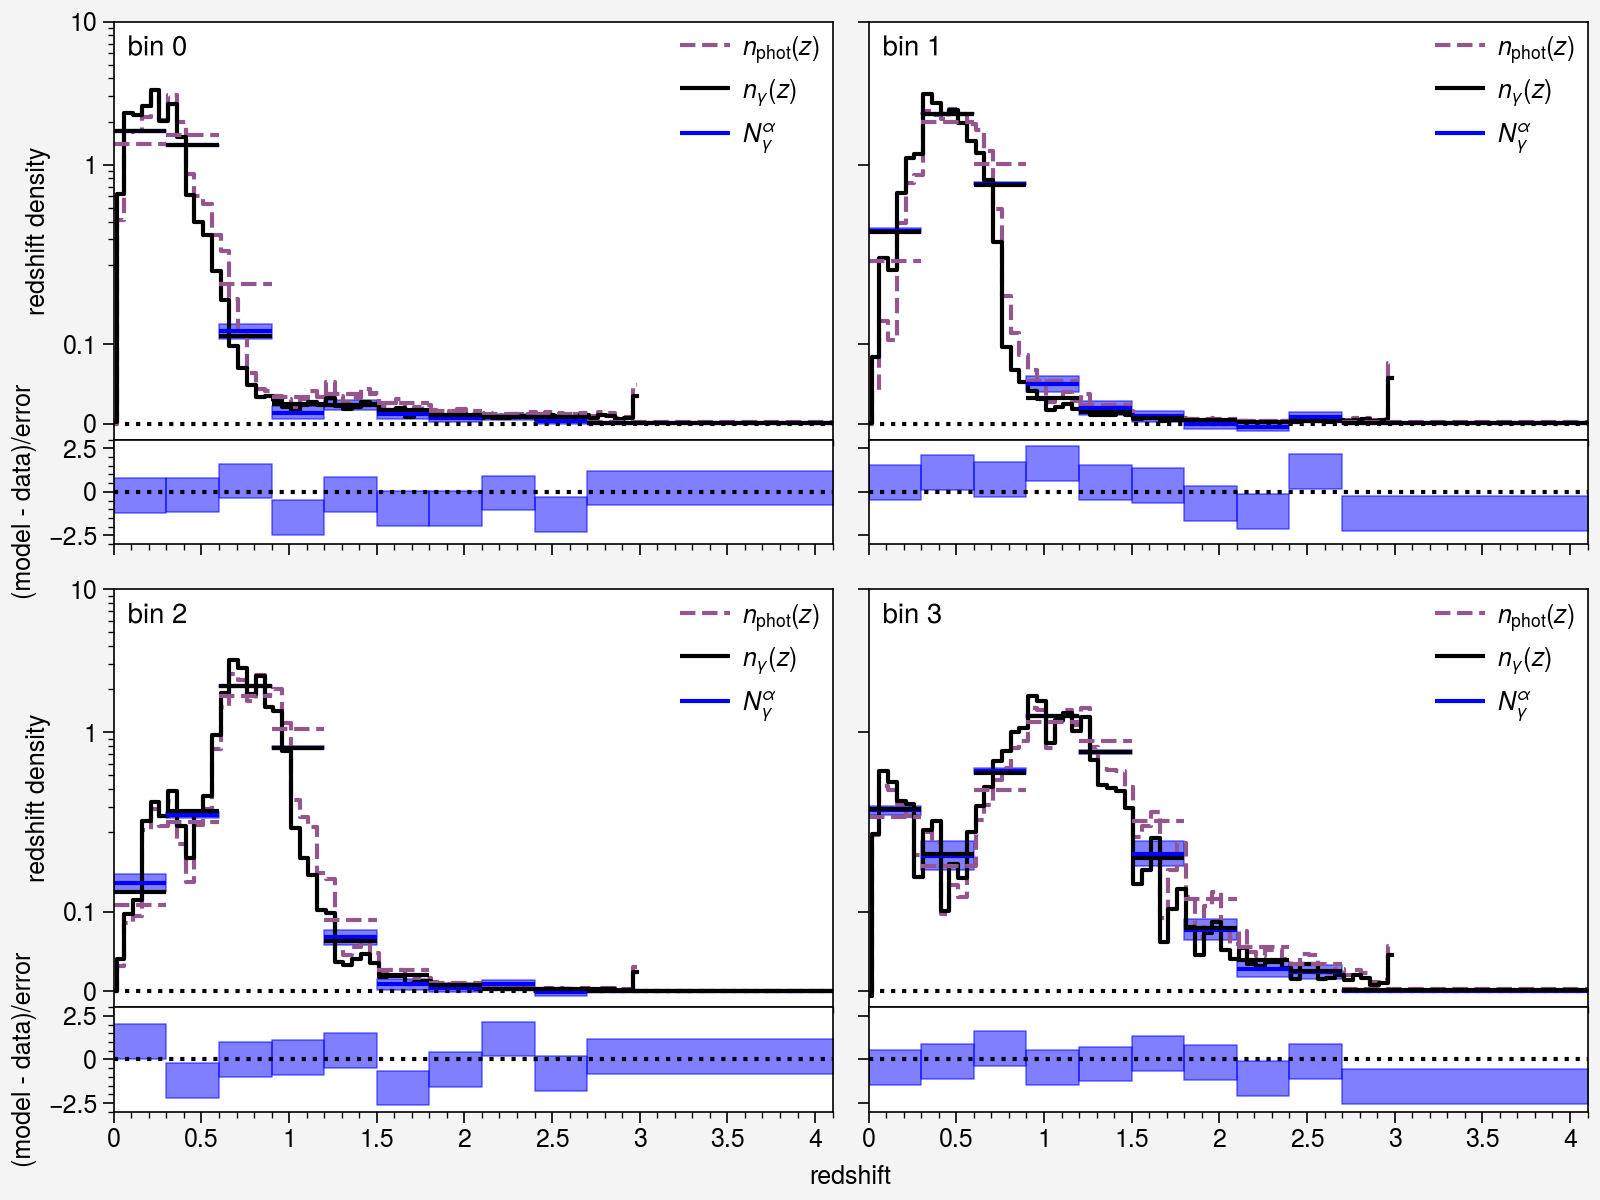

In [11]:
from des_y6_nz_modeling import plot_results

fig = plot_results(model_module=model_module, model_data=model_data, map_params=map_params)

# MCMC

In [ ]:
from jax import random
from numpyro.infer import init_to_sample, init_to_value

rng_key = random.PRNGKey(42)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(
    model_module.model,
    init_strategy=init_to_sample(),  # init_to_value(values=map_params),
    max_tree_depth=10,
)
mcmc = MCMC(
    kernel,
    num_warmup=500,
    num_samples=1000,
    num_chains=4,
)
mcmc.run(
    rng_key_,
    **model_data,
)


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [13]:

mcmc.print_summary()
samples = mcmc.get_samples()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     a0_b0     -0.06      0.07     -0.06     -0.18      0.06   4597.57      1.00
     a0_b1     -0.05      0.09     -0.06     -0.20      0.08   3839.31      1.00
     a0_b2     -0.03      0.06     -0.02     -0.13      0.07   1173.01      1.00
     a0_b3      0.04      0.06      0.04     -0.05      0.13   3511.66      1.00
     a1_b0     -0.21      0.06     -0.21     -0.33     -0.11   2331.53      1.00
     a1_b1     -0.18      0.06     -0.18     -0.27     -0.09   2686.86      1.00
     a1_b2     -0.03      0.03     -0.04     -0.07      0.01   2078.36      1.00
     a1_b3     -0.17      0.04     -0.17     -0.24     -0.10   2081.08      1.00
     a2_b0      0.03      0.03      0.03     -0.01      0.08   1849.45      1.00
     a2_b1      0.02      0.05      0.03     -0.05      0.10   1539.16      1.00
     a2_b2     -0.03      0.02     -0.03     -0.06     -0.00    752.69      1.00
     a2_b3      0.02      0

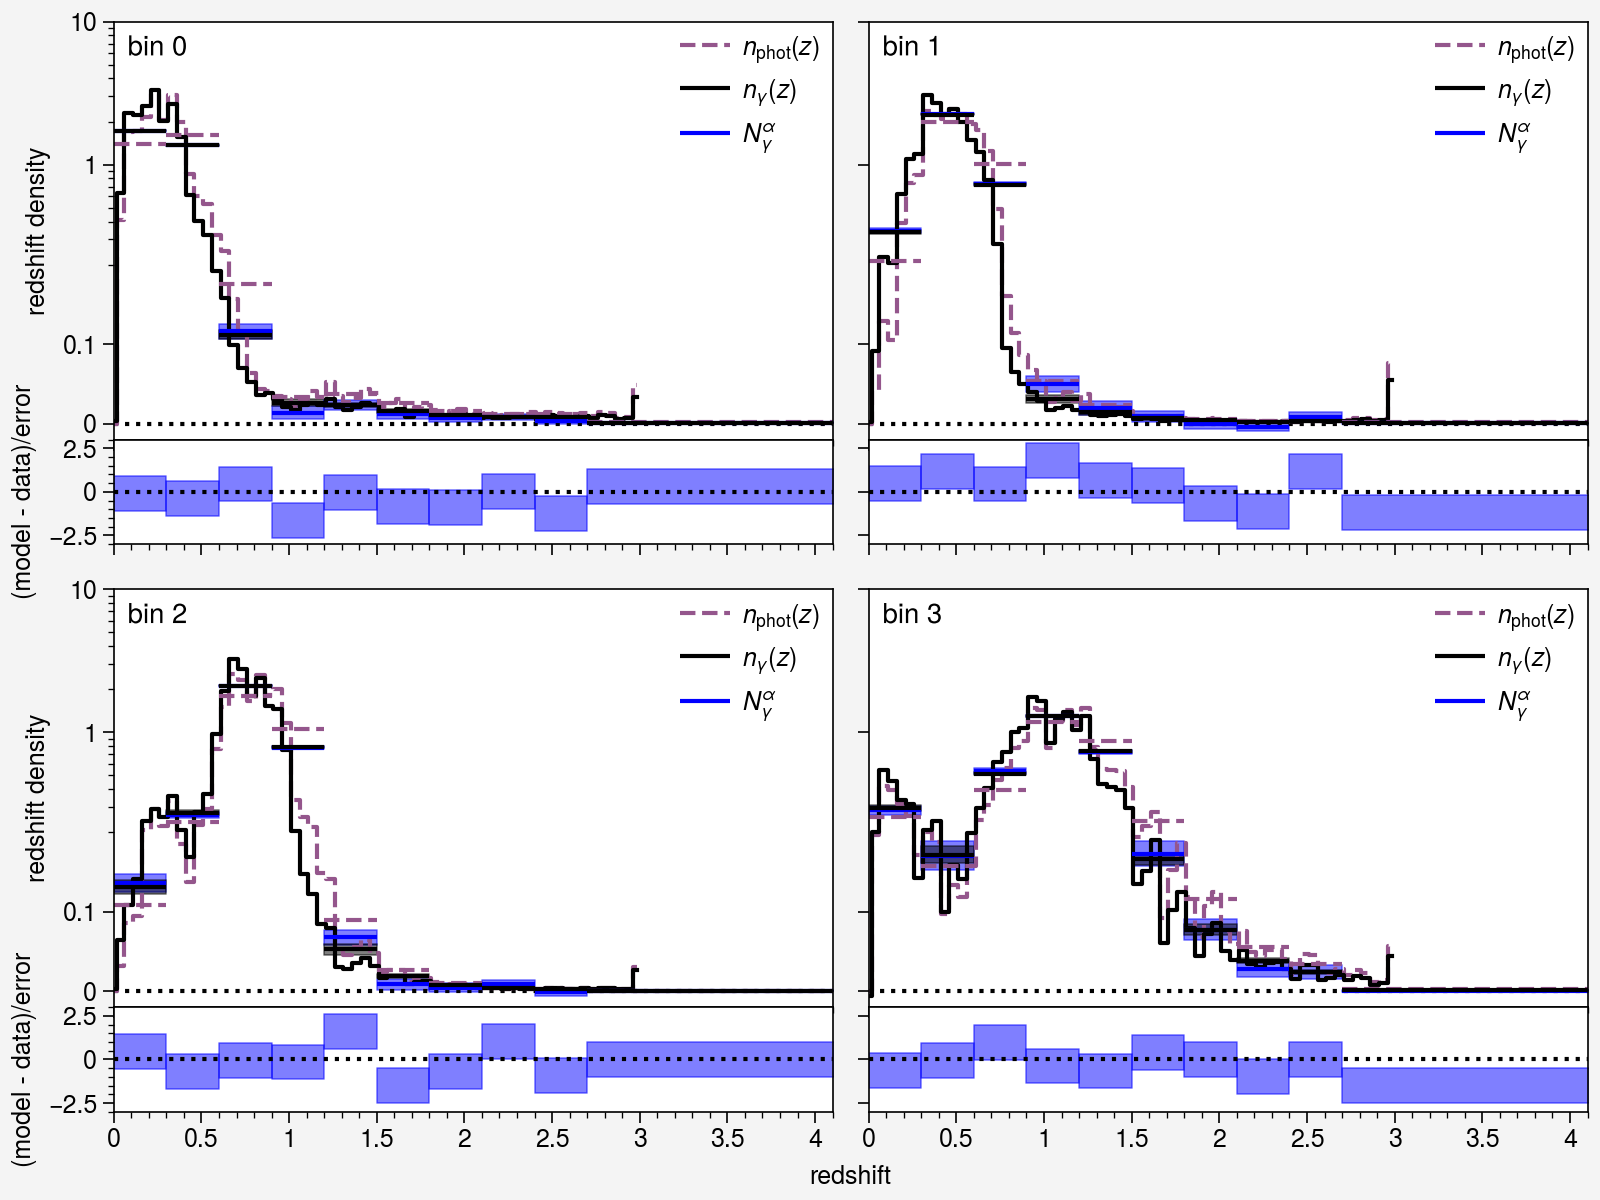

In [14]:
from des_y6_nz_modeling import plot_results

fig = plot_results(model_module=model_module, model_data=model_data, samples=samples)
# fig.savefig("fgfit.pdf")
# fig.savefig("fgfit.png", dpi=600)

In [15]:
from des_y6_nz_modeling import measure_m_dz

data = measure_m_dz(model_module=model_module, model_data=model_data, samples=samples, return_dict=False)

In [16]:
m_mn = data.mean(axis=0)[[0, 2, 4, 6]]
m_sd = data.std(axis=0, ddof=1)[[0, 2, 4, 6]]

dz_mn = data.mean(axis=0)[[1, 3, 5, 7]]
dz_sd = data.std(axis=0, ddof=1)[[1, 3, 5, 7]]

In [17]:
print("|--------------------------------------------|")
print("| bin | m [10^-3, 3sigma] | dz               |")
print("|--------------------------------------------|")
for i in range(4):
    print("| %d   | %+5.1f +/- %-5.1f   | %+0.3f +/- %0.3f |" % (i, m_mn[i]/1e-3, m_sd[i]/1e-3 * 3, dz_mn[i], dz_sd[i]))
print("|--------------------------------------------|")

|--------------------------------------------|
| bin | m [10^-3, 3sigma] | dz               |
|--------------------------------------------|
| 0   |  -7.5 +/- 18.7    | -0.051 +/- 0.005 |
| 1   | +13.1 +/- 25.3    | -0.051 +/- 0.004 |
| 2   | +19.1 +/- 23.1    | -0.041 +/- 0.004 |
| 3   |  +7.0 +/- 38.4    | -0.074 +/- 0.009 |
|--------------------------------------------|
